## Assignment 1: Data Prep & Simple Model Fit

1. Import `income.csv` and run your data prep function on it
2. Fit a logistic regression to predict income class using just the `age` and `hoursperweek` variables as features.
3. Take some time to interpet the impact of age on the probability someone makes over 50k. What is the impact of a one year increase in age?
4. Plot age vs. predicted probability.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
import os
os.listdir('/content')

['.config', 'income.csv', 'sample_data']

In [2]:
from google.colab import files
uploaded = files.upload()

Saving income.csv to income.csv


In [3]:
income = pd.read_csv("income.csv")
income.head()

age       JobType         EdType        maritalstatus       occupation  \
0   45       Private        HS-grad             Divorced     Adm-clerical   
1   24   Federal-gov        HS-grad        Never-married     Armed-Forces   
2   44       Private   Some-college   Married-civ-spouse   Prof-specialty   
3   27       Private            9th        Never-married     Craft-repair   
4   20       Private   Some-college        Never-married            Sales   

      relationship    race   gender  capitalgain  capitalloss  hoursperweek  \
0    Not-in-family   White   Female            0            0            28   
1        Own-child   White     Male            0            0            40   
2          Husband   White     Male            0            0            40   
3   Other-relative   White     Male            0            0            40   
4    Not-in-family   White     Male            0            0            35   

    nativecountry                        SalStat  
0   United-States   less than or equal to 50,000  
1   United-States   less than or equal to 50,000  
2   United-States            greater than 50,000  
3          Mexico   less than or equal to 50,000  
4   United-States   less than or equal to 50,000

In [4]:
def income_model_prep(data):
    from sklearn.model_selection import train_test_split
    data = pd.get_dummies(
        data.assign(
            target = np.where(data["SalStat"] == " less than or equal to 50,000", 0, 1),
            nativecountry = data["nativecountry"].replace({" Holand-Netherlands": " Germany"}),
            occupation = data["occupation"].replace({" Armed-Forces": " ?"}),
            JobType = data["JobType"].replace({" Never-worked": " Without-pay"}),
        ).drop("SalStat", axis=1),
        drop_first=True
    )
    X = data.drop("target", axis=1).loc[:,['age','hoursperweek']]
    y = data["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = income_model_prep(income)

In [5]:
from sklearn.linear_model import LogisticRegression
loreg = LogisticRegression()
lr = loreg.fit(X_train , y_train)

In [6]:
loreg_coeff = pd.DataFrame({"Coefficient": lr.coef_.ravel()
                            } , index = [f"beta{i+1}" for i in range(len(lr.coef_.ravel()))]
                           )
loreg_coeff.loc["Intercept"] = lr.intercept_
loreg_coeff

Coefficient
beta1         0.042769
beta2         0.048745
Intercept    -4.933043

In [7]:
score_df = pd.DataFrame({"Training accuracy" : lr.score(X_train , y_train),
                         "Test accuracy": lr.score(X_test , y_test)
                         } , index = ['Scores'])
score_df.T

Scores
Training accuracy  0.753381
Test accuracy      0.757036

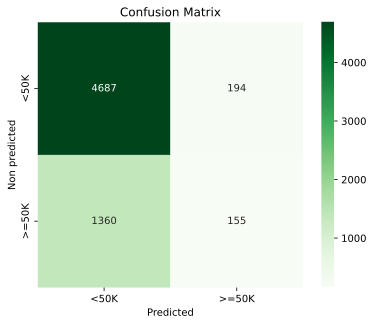

In [8]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test , lr.predict(X_test))
sns.heatmap(conf_matrix ,
            cmap = 'Greens',
            annot = True,
            fmt = 'g',
            square = True,
            xticklabels = ["<50K" , ">=50K"],
            yticklabels = ["<50K" , ">=50K"],
            ).set(
                xlabel = 'Predicted',
                ylabel = "Non predicted",
                title = 'Confusion Matrix'
                  )
plt.show()

In [9]:
np.exp(lr.coef_)

array([[1.04369717, 1.04995224]])

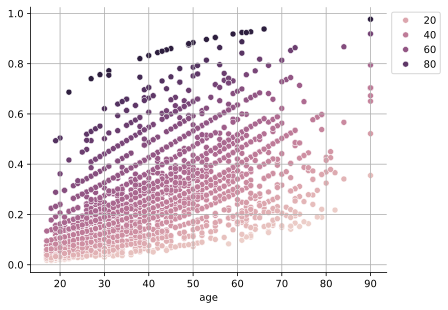

In [10]:
sns.scatterplot(x = X_test['age'],
                y = lr.predict_proba(X_test[['age', 'hoursperweek']])[:,1],
                hue = X_test['hoursperweek']
                ).legend(bbox_to_anchor = (1,1))
plt.grid()
sns.despine()

In [11]:
sns.jointplot(x = X_test['age'] ,
              y = lr.predict_proba(X_test[['age', 'hoursperweek']])[:,1],
              hue = X_test['hoursperweek'])

sns.despine()

## Assignment 2: Model Tuning

1. Fit a Regression using all available features - remove features if it appears there is overfitting.

2. Tune the regularization paramters once you've decided on a set of features.

In [12]:
def income_model_prep(data):
    from sklearn.model_selection import train_test_split
    data = pd.get_dummies(
        data.assign(
            target = np.where(data["SalStat"] == " less than or equal to 50,000", 0, 1),
            nativecountry = data["nativecountry"].replace({" Holand-Netherlands": " Germany"}),
            occupation = data["occupation"].replace({" Armed-Forces": " ?"}),
            JobType = data["JobType"].replace({" Never-worked": " Without-pay"}),
        ).drop("SalStat", axis=1),
        drop_first=True
    )
    X = data.drop("target", axis=1)
    y = data["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = income_model_prep(income)

In [13]:
from sklearn.linear_model import LogisticRegression
loreg = LogisticRegression(max_iter = 5000)
lr = loreg.fit(X_train , y_train)

lr_dic_score = pd.DataFrame({"Train Score" : lr.score(X_train , y_train),
                             "Test Score" : lr.score(X_test , y_test)
                             }, index = ['score'])
lr_dic_score.T

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score
Train Score  0.851654
Test Score   0.855847

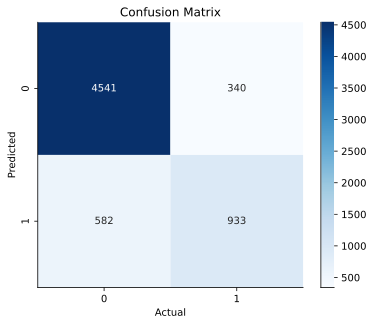

In [14]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(y_test , lr.predict(X_test))
sns.heatmap(con_mat,
            annot = True,
            cmap = 'Blues',
            fmt = 'g',
            square = True
            ).set(xlabel = 'Actual',
                  ylabel = 'Predicted',
                  title = 'Confusion Matrix')
sns.despine()

In [15]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {
    "C": np.linspace(0.1 , 2 , 20),
    "penalty" : ["l1", "l2", "elasticnet"],
    "l1_ratio": np.linspace(0,1,11)
}

gridsearch = GridSearchCV(LogisticRegression(solver = 'saga', max_iter = 1000), parameters)
gridsearch.fit(X_train_std , y_train)
gridsearch.best_params_

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_

# Multiclass Logistic Regression

1. Fit a multiclass logistic regression on the data below
2. Create a confusion matrix and report accuracy score for the test data.

In [16]:
from google.colab import files
uploaded = files.upload()

Saving credit_train_clean.csv to credit_train_clean.csv


In [17]:
import pandas as pd

credit_df = pd.read_csv("credit_train_clean.csv").drop(["Name", "SSN"], axis=1)
credit_df.head()

ID  Customer_ID  Month   Age Occupation  Annual_Income  \
0  5634         3392      1  23.0  Scientist       19114.12   
1  5635         3392      2  23.0  Scientist       19114.12   
2  5636         3392      3  23.0  Scientist       19114.12   
3  5637         3392      4  23.0  Scientist       19114.12   
4  5638         3392      5  23.0  Scientist       19114.12   

   Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  \
0            1824.843333                3.0              4.0            3.0   
1            1824.843333                3.0              4.0            3.0   
2            1824.843333                3.0              4.0            3.0   
3            1824.843333                3.0              4.0            3.0   
4            1824.843333                3.0              4.0            3.0   

   ...  Credit_Mix Outstanding_Debt  Credit_Utilization_Ratio  \
0  ...        Good           809.98                 26.822620   
1  ...        Good           809.98                 31.944960   
2  ...        Good           809.98                 28.609352   
3  ...        Good           809.98                 31.377862   
4  ...        Good           809.98                 24.797347   

   Credit_History_Age  Payment_of_Min_Amount  Total_EMI_per_month  \
0               265.0                     No            49.574949   
1               266.0                     No            49.574949   
2               267.0                     No            49.574949   
3               268.0                     No            49.574949   
4               269.0                     No            49.574949   

  Amount_invested_monthly                 Payment_Behaviour  Monthly_Balance  \
0                21.46538   High_spent_Small_value_payments       312.494089   
1                21.46538    Low_spent_Large_value_payments       284.629162   
2                21.46538   Low_spent_Medium_value_payments       331.209863   
3                21.46538    Low_spent_Small_value_payments       223.451310   
4                21.46538  High_spent_Medium_value_payments       341.489231   

   Credit_Score  
0          Good  
1          Good  
2          Good  
3          Good  
4          Good  

[5 rows x 26 columns]

In [18]:
credit_df["Credit_Score"].value_counts()

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split

features = [
    "Age",
    "Month",
    "Annual_Income",
    "Num_Bank_Accounts",
    "Changed_Credit_Limit",
    "Num_Credit_Card",
    "Credit_History_Age",
    "Payment_of_Min_Amount",
    "Monthly_Balance",
    "Payment_Behaviour",
    "Num_Credit_Inquiries",
    "Outstanding_Debt",
    "Credit_Mix",
    "Total_EMI_per_month"
]

X = pd.get_dummies(credit_df[features], dtype="int", drop_first=True)
y = credit_df["Credit_Score"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [21]:
X_test.head()

Age  Month  Annual_Income  Num_Bank_Accounts  Changed_Credit_Limit  \
65740  42.0      5       39849.72                9.0                  9.12   
11139  50.0      4       16558.12                3.0                  3.57   
99196  35.0      5       96047.22                3.0                  4.75   
33120  26.0      1       32904.13                2.0                  7.43   
41199  27.0      8       32428.98                6.0                 21.88   

       Num_Credit_Card  Credit_History_Age  Monthly_Balance  \
65740              8.0                73.0       384.540284   
11139              7.0               232.0       247.055794   
99196              3.0               212.0       742.619597   
33120              7.0               189.0       326.879129   
41199              5.0               132.0       329.887223   

       Num_Credit_Inquiries  Outstanding_Debt  Total_EMI_per_month  \
65740                  14.0           2533.64            96.604035   
11139                   1.0             15.43            35.387555   
99196                   4.0           1366.21            49.656727   
33120                   2.0            781.45            46.033182   
41199                  11.0           4903.14           109.273296   

       Payment_of_Min_Amount_No  Payment_of_Min_Amount_Yes  \
65740                         0                          1   
11139                         1                          0   
99196                         1                          0   
33120                         1                          0   
41199                         0                          0   

       Payment_Behaviour_High_spent_Medium_value_payments  \
65740                                                  0    
11139                                                  0    
99196                                                  1    
33120                                                  0    
41199                                                  0    

       Payment_Behaviour_High_spent_Small_value_payments  \
65740                                                  0   
11139                                                  0   
99196                                                  0   
33120                                                  1   
41199                                                  0   

       Payment_Behaviour_Low_spent_Large_value_payments  \
65740                                                 0   
11139                                                 0   
99196                                                 0   
33120                                                 0   
41199                                                 0   

       Payment_Behaviour_Low_spent_Medium_value_payments  \
65740                                                  1   
11139                                                  0   
99196                                                  0   
33120                                                  0   
41199                                                  1   

       Payment_Behaviour_Low_spent_Small_value_payments  Credit_Mix_Good  \
65740                                                 0                0   
11139                                                 1                1   
99196                                                 0                1   
33120                                                 0                1   
41199                                                 0                0   

       Credit_Mix_Standard  
65740                    1  
11139                    0  
99196                    0  
33120                    0  
41199                    0

In [22]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.612
0.60755


In [23]:
lr.classes_

array(['Good', 'Poor', 'Standard'], dtype=object)

In [24]:
y_train.value_counts()

Credit_Score
Standard    42587
Poor        23183
Good        14230
Name: count, dtype: int64

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, lr.predict(X_train))

array([[ 3203,   217, 10810],
       [  724, 11390, 11069],
       [ 2243,  5977, 34367]])

In [27]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
rf.fit(X_train, y_train)

rf.score(X_test, y_test)

0.7881